In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import seaborn as sns

%matplotlib inline

## read in the data

In [2]:
data = pd.read_csv('youtube-comments.csv')

In [3]:
data.head()

,comment,troll,title,views,dislikes,commentCount,likes,replies,id
0,"What a lucky guy, got celebrated birthday on c...",0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
1,Love it﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
2,no americans even knew who corden was several ...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
3,my birthday was the 22nd as well and we both s...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w
4,OMG IM CRYING﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w


## cleaning the text

In [4]:
def cleaner(text):
    '''Function to clean the text data and prep for further analysis'''
    stops = set(stopwords.words("english"))     # Creating a set of Stopwords
    p_stemmer = PorterStemmer()                 # Creating the stemmer model
    text = re.sub("[^a-zA-Z]"," ",text)          # Removes punctuation
    text = text.split()                          # Splits the data into individual words 
    text = [w for w in text if not w in stops]   # Removes stopwords
    text = [p_stemmer.stem(i) for i in text]     # Stemming (reducing words to their root)
    return ' '.join(text)

In [5]:
data['clean'] = data['comment'].apply(cleaner)

In [6]:
data.head()

,comment,troll,title,views,dislikes,commentCount,likes,replies,id,clean
0,"What a lucky guy, got celebrated birthday on c...",0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,What lucki guy got celebr birthday concert bil...
1,Love it﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,Love
2,no americans even knew who corden was several ...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,american even knew corden sever year ago
3,my birthday was the 22nd as well and we both s...,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,birthday nd well support west ham
4,OMG IM CRYING﻿,0,Nothing Compares 2 U (Live in LA w/ James Corden),469414,263,1123,19392,0,mak_Cu9Wl6w,OMG IM CRi


## using tf-idf to convert the clean comments to a matrix of freq's

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

In [8]:
vectorizer = TfidfVectorizer(lowercase=False,
                             analyzer=u'word',
                             ngram_range=(1, 3),
                             stop_words='english',
                             binary=False,
                             norm=u'l2', 
                             use_idf=True, 
                             smooth_idf=True, 
                             sublinear_tf=True,
                             min_df=3)
X = vectorizer.fit_transform(data.clean)

In [9]:
vectorizer = TfidfVectorizer(lowercase=False,
                             analyzer=u'char',
                             ngram_range=(1, 5),
                             stop_words='english',
                             binary=False,
                             norm=u'l2', 
                             use_idf=True, 
                             smooth_idf=True, 
                             sublinear_tf=True)
X = vectorizer.fit_transform(data.clean)

In [10]:
X.shape

(3935, 102366)

## creating labels

In [11]:
le = preprocessing.LabelEncoder()
le.fit(data.troll.values)
Y = le.transform(data.troll.values) 

## defining a classifier function

the fact that only 10% of the data is trolls means that maybe an anamoly detection approach would perform better, this is taken care of by giving the classifier the flag class_weight='balanced' that ensures a balanced sampling of the input data

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def model_rfc(X, Y, troll):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.80)
    
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
    clf.fit(X_train, y_train)
    clf_probs = np.dot(clf.predict_proba(X_test)>0.5, np.array([0, 1]))
    
    score = confusion_matrix(y_test, clf_probs)
    
    print('confidence matrix:')
    print(score)
    plt.bar(range(X.shape[1]), clf.feature_importances_)
    
    clf_labels = np.dot(clf.predict_proba(X)>0.5, np.array([0, 1]))
    print('False Positives:')
    print('================')
    print(data['comment'][(clf_labels==1) & (troll==0)])
    print('False Negatives:')
    print('================')
    print(data['comment'][(clf_labels==0) & (troll==1)])
    
    return 

## dimensionality reduction

tf-idf vectorizer gives around 5500 words (columns) and that's more than the number of rows, and since most words are redundant anyway it is important to reduce the dimensionality of the problem

### Percentile Threshold 
Select features according to a percentile of the highest scores

In [13]:
from sklearn.feature_selection import SelectPercentile, chi2

In [14]:
sel = SelectPercentile(score_func=chi2, percentile=1)

In [15]:
X_sel = sel.fit_transform(X, Y)

In [16]:
X_sel.shape

(3935, 1023)

## classifying using the result of PCA

confidence matrix:
[[705   6]
 [ 57  19]]
False Positives:
435                                                  wtf﻿
766                                                  wtf﻿
1159                      I fucked 1,000 bitches - Lil B﻿
1287    this dude always complaining tho diaz fan for ...
2558    I fucking love this song. If only it were longer﻿
2640                               what the fuck is that﻿
2800                                   WHAT IS THIS EVEN﻿
2815                                       fucking 10/10﻿
2829                                                 Wtf﻿
2913    tell me this how do u get in the bed with devi...
3201    Filmed sideways like a dumb retard from the Un...
Name: comment, dtype: object
False Negatives:
13      wot a surprise can&#39;t get away from his cub...
17      This clown is like shit on a field. Unfunny fa...
464              Another shitty female lead action movie﻿
592     Why is this kind of stuff on YouTube. It&#39;s...
716     if he laughed in 

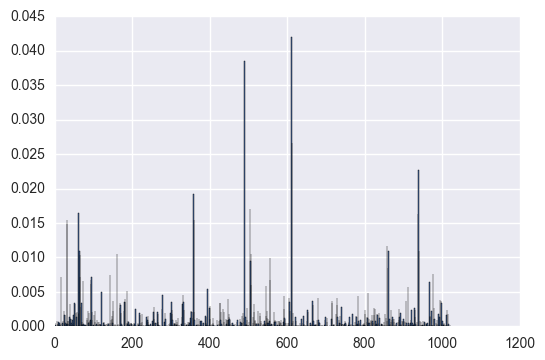

In [17]:
model_rfc(X_sel, Y, data.troll)

## creating new features based on the length of the comment etc

In [18]:
def bad_word_counter(text):
    bad_words = pd.read_csv('google_badlist.txt', header=None).values
    return len([w for w in text.split() if w in bad_words])

In [19]:
def transform(documents):
    ## some handcrafted features!
    n_words = [len(c.split()) for c in documents]
    n_chars = [len(c) for c in documents]
    # number of uppercase words
    allcaps = [np.sum([w.isupper() for w in comment.split()])
           for comment in documents]
    # longest word
    max_word_len = [np.max([len(w) for w in c.split()]) for c in documents]
    # average word length
    mean_word_len = [np.mean([len(w) for w in c.split()])
                                        for c in documents]
    # number of google badwords:
    n_bad = [bad_word_counter(c) for c in documents]
    exclamation = [c.count("!") for c in documents]
    addressing = [c.count("@") for c in documents]
    spaces = [c.count(" ") for c in documents]

    allcaps_ratio = np.array(allcaps) / np.array(n_words, dtype=np.float)
    bad_ratio = np.array(n_bad) / np.array(n_words, dtype=np.float)
    
    counts = np.array([n_words, n_chars, allcaps, max_word_len,
                       mean_word_len, exclamation, addressing, spaces,
                       n_bad]).T
    ratios = np.array([allcaps_ratio, bad_ratio]).T

    return counts, ratios

## classifying based on the features like the length of the comment etc

In [20]:
from sklearn.preprocessing import scale

In [21]:
counts, ratios = transform(data.comment)

In [22]:
np.var(counts, axis=0)

array([  4.88872874e+02,   1.55130994e+04,   1.06268625e+01,
         1.83229048e+02,   9.56477901e+00,   7.36037612e+00,
         2.79019454e-03,   6.30713697e+02,   1.81380986e-01])

In [23]:
np.var(ratios, axis=0)

array([ 0.03757508,  0.00188708])

In [24]:
X_ext = scale(np.concatenate((counts, ratios), axis=1), with_mean=True, axis=0)

confidence matrix:
[[653  77]
 [ 45  12]]
False Positives:
2       no americans even knew who corden was several ...
3       my birthday was the 22nd as well and we both s...
14                                                   lol﻿
32                             has james put on weight ?﻿
34                        Sorry, James Corden not Conrad﻿
53      can&#39;t wait to see you guys this december i...
63                               Maine Mendoza was here.﻿
68                   great song :)) always love Coldplay﻿
81                                                   😍😍😍﻿
89                         ©©<br />..+..<br />Thank you.﻿
97                                                   Oh🤔﻿
109                                        Word of Tanks﻿
119                                    But still though?﻿
132                                           Irish pleb﻿
147       brock lesnar is probably gonna try and rake it﻿
156                                          wwe is fake﻿
161          

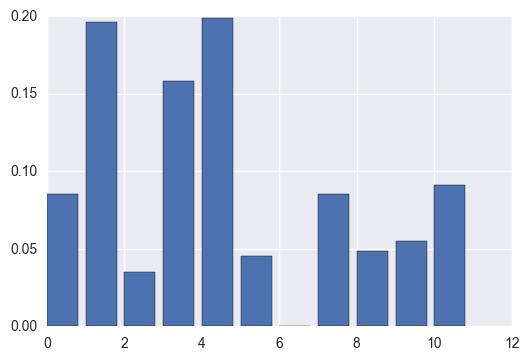

In [25]:
model_rfc(X_ext, Y, data.troll)

## classifying based on generated features

In [29]:
X_sel.shape

(3935, 1023)

confidence matrix:
[[691   9]
 [ 75  12]]
False Positives:
302     well wel you not find it there would you its i...
693                                     Cured my cancer.﻿
1329    Nate is in worse shape than than the amateurs ...
1508              Fucking greatness, I need one of those﻿
1608                            This is so fucking cute.﻿
1776      Why are stupid guys so freaking hot oh my god😭﻿
2320    What&#39;s wrong with imigrants ur fucking cou...
2597                      This comment section is cancer﻿
2660                                     Fucking bogging﻿
2829                                                 Wtf﻿
Name: comment, dtype: object
False Negatives:
13      wot a surprise can&#39;t get away from his cub...
17      This clown is like shit on a field. Unfunny fa...
236       ehhh fine...i&#39;ll give ya a like..assholes.﻿
331       was that good for a blackman chucking a spear?﻿
380                                   Well that was shit﻿
466     Dafaq is this shi

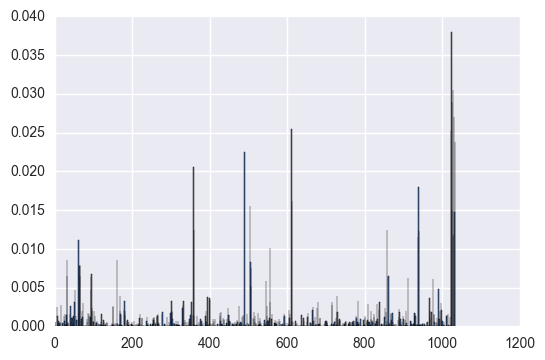

In [30]:
model_rfc(np.concatenate((X_sel.toarray(), X_ext), axis=1), Y, data.troll)

## visualizing some of the features

In [ ]:
colors = ['r', 'b']
label_colors = [colors[lab] for lab in data.troll.values]

plt.scatter(X_pca[:,3], X_pca[:,2], 
            s=10,
            lw=0.1,
            c=label_colors,
            alpha=0.3)

In [ ]:
a = plt.hist(X_ext[:,-1], bins=100)

## using isolation forest

In [ ]:
from sklearn.ensemble import IsolationForest

def model_ifc(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.80)
    clf = IsolationForest(n_estimators=100)
    clf.fit(X_train, y_train)
    clf_probs = clf.predict(X_test) < 0
    score = confusion_matrix(y_test, clf_probs)
    print(score)

In [ ]:
model_ifc(X_pca, Y)

# Questions
* does it make sense to do variance based feature selection when dealing with imbalanced label sizes?